## Load the Dependencies / Print Versions

In [2]:
from tensorflow.keras.preprocessing.image import save_img
from keras.preprocessing import image as keras_image
from keras.applications.vgg19 import VGG19
from scipy.optimize import fmin_l_bfgs_b
from platform import python_version
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras import backend
import matplotlib as mpl
tf.disable_v2_behavior()
from PIL import Image
import numpy as np
import time

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
print('Python Version=', python_version())
print('Tensorflow Version=', tf.__version__)
print('Numpy Version =', np.version.version)

Python Version= 3.8.8
Tensorflow Version= 2.7.0
Numpy Version = 1.20.1


## Define the Globals

In [5]:
image_size = 512
epochs = 15
channels = 3
content_weight = 0.02
style_weight = 4.5
total_variation_weight = 0.995
total_variation_loss_factor = 1.25

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
backend.set_session(tf.Session(config = config))

## Define the content and style images

In [7]:
content_path = 'Lawton Nicole.jpg'
style_path = 'Mosaic.jpg'
saved_image_filename = 'LN Mosaic.jpg'

## Define the size of the generated images

In [8]:
image = Image.open(content_path)
long = max(image.size)
scale = image_size / long
image_width = round(image.size[0] * scale)
image_height = round(image.size[1] * scale)

In [9]:
def load_and_process_image(image_path):
    image = Image.open(image_path)
    image = image.resize((image_width, image_height), Image.ANTIALIAS)
    image = keras_image.img_to_array(image, dtype = 'float32')
    image = np.expand_dims(image, axis = 0)
    image[:, :, :, 0] -= 103.939
    image[:, :, :, 1] -= 116.779
    image[:, :, :, 2] -= 123.68
    image = image[:, :, :, ::-1]
    return image

In [10]:
def deprocess_image(input_image):
    new_image = input_image.copy()
    new_image = new_image.reshape((image_height, image_width, channels))
    new_image = new_image[:, :, ::-1]
    new_image[:, :, 0] += 103.939
    new_image[:, :, 1] += 116.779
    new_image[:, :, 2] += 123.68
    new_image = np.clip(new_image, 0, 255).astype("uint8")
    return new_image

In [11]:
def display_image(image, title):
    image = deprocess_image(image)

    plt.figure(figsize = (10, 8))
    plt.title = title
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    return

## Turn the images into arrays

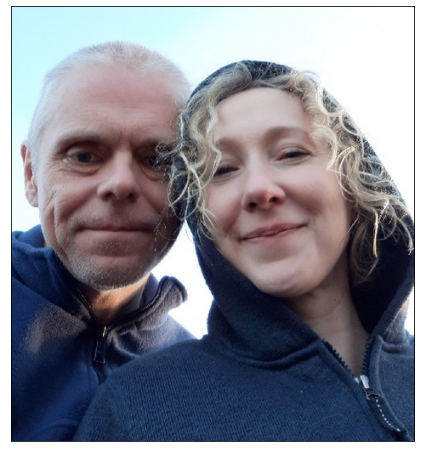

In [12]:
content_image_array = load_and_process_image(content_path)
display_image(content_image_array, 'Content Image')

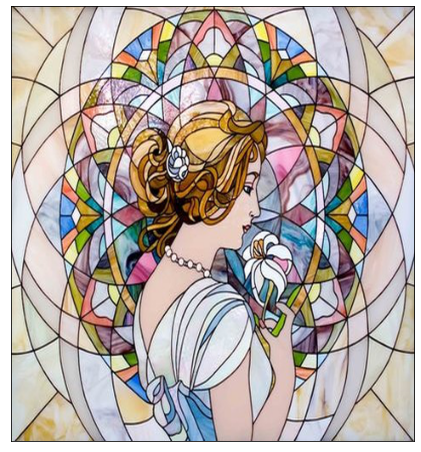

In [13]:
style_image_array = load_and_process_image(style_path)
display_image(style_image_array, 'Style Image')

## Turn the arrays into tensors

In [14]:
content_image = backend.variable(content_image_array)
style_image = backend.variable(style_image_array)
generated_image = backend.placeholder((1, image_height, image_width, channels))

## Load the model

In [15]:
input_tensor = backend.concatenate([content_image, style_image, generated_image], axis = 0)
model = VGG19(input_tensor = input_tensor, include_top = False)

# Define the content layer and style layers to be used

In [16]:
content_layer = 'block2_conv2'
style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [17]:
layer_features = layers[content_layer]
content_features = layer_features[0, :, :, :]
generated_features = layer_features[2, :, :, :]

## Define the content loss, style loss, and total variation loss

In [18]:
def content_loss(content, generated):
    return backend.sum(backend.square(generated - content))

In [19]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [20]:
def compute_style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    size = image_height * image_width
    return backend.sum(backend.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

In [21]:
def total_variation_loss(some_image):
    a = backend.square(some_image[:, :image_height - 1, :image_width - 1, :] - some_image[:, 1:, :image_width - 1, :])
    b = backend.square(some_image[:, :image_height - 1, :image_width - 1, :] - some_image[:, :image_height - 1, 1:, :])
    return backend.sum(backend.pow(a + b, total_variation_loss_factor))

## Calculate the total loss

In [22]:
loss = backend.variable(0.)
loss = loss + content_weight * content_loss(content_features, generated_features)

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * style_loss

loss += total_variation_weight * total_variation_loss(generated_image)    

In [23]:
class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

In [24]:
def evaluate_loss_and_gradients(some_image):
    some_image = some_image.reshape((1, image_height, image_width, channels))
    outs = backend.function([generated_image], outputs)([some_image])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

In [25]:
outputs = [loss]
outputs += backend.gradients(loss, generated_image)

## Begin the NST loop, minimizing loss and gradients

In [26]:
def neural_style_transfer():
    evaluator = Evaluator()
    progress = np.random.uniform(0, 255, (1, image_height, image_width, channels)) - 128.
    start_time = time.time()
    for lp in range(epochs):
        progress, loss, info = fmin_l_bfgs_b(evaluator.loss, progress.flatten(), fprime = evaluator.gradients, maxfun = 20)
        print("Epoch(%d)  Loss = %d, Time = %d seconds" % (lp + 1, loss, round((time.time() - start_time),2)))
    return progress

In [27]:
generated_image = neural_style_transfer()

Epoch(1)  Loss = 146178867200, Time = 251 seconds
Epoch(2)  Loss = 83178913792, Time = 492 seconds
Epoch(3)  Loss = 58013958144, Time = 721 seconds
Epoch(4)  Loss = 47194857472, Time = 963 seconds
Epoch(5)  Loss = 43543068672, Time = 1208 seconds
Epoch(6)  Loss = 41801289728, Time = 1454 seconds
Epoch(7)  Loss = 40434241536, Time = 1693 seconds
Epoch(8)  Loss = 39407419392, Time = 1929 seconds
Epoch(9)  Loss = 38804774912, Time = 2226 seconds
Epoch(10)  Loss = 38030467072, Time = 2520 seconds
Epoch(11)  Loss = 37390753792, Time = 2773 seconds
Epoch(12)  Loss = 36863070208, Time = 3015 seconds
Epoch(13)  Loss = 36446679040, Time = 3268 seconds
Epoch(14)  Loss = 36052865024, Time = 3511 seconds
Epoch(15)  Loss = 35747414016, Time = 3765 seconds


In [28]:
generated_image = deprocess_image(generated_image)
generated_image = keras_image.array_to_img(generated_image)

In [29]:
def imshow(image):
    image = np.squeeze(image, axis = 0)
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    image = image[:, :, ::-1]
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)

## Display and save the final results

In [30]:
def show_final_results(content, style, generated):
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    imshow(content)
    plt.subplot(1, 2, 2)
    imshow(style)
    plt.figure(figsize = (10, 10))
    plt.imshow(generated)
    plt.show()

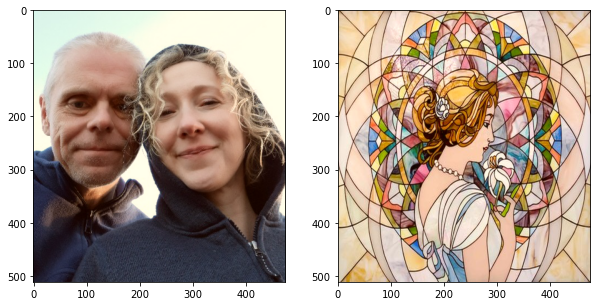

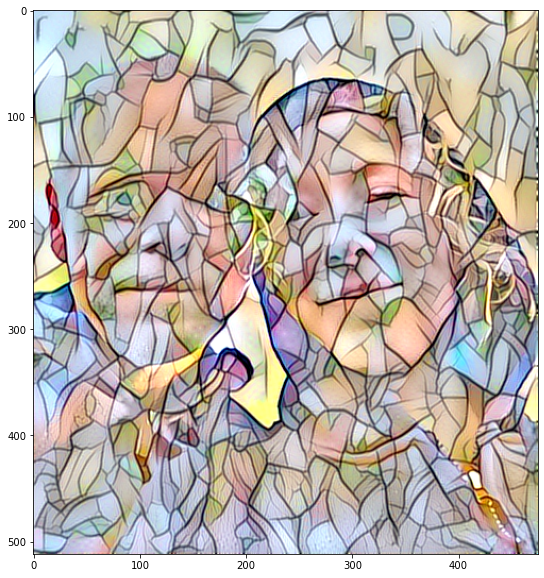

In [31]:
show_final_results(load_and_process_image(content_path), load_and_process_image(style_path), generated_image)

In [32]:
save_img(saved_image_filename, generated_image)